In [137]:
import sunpy
import sunpy.map
from sunpy.net import vso
from sunpy.net import attrs

import datetime
from datetime import datetime
from datetime import timedelta

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.samp import SAMPIntegratedClient
from astropy.utils.console import ProgressBar

from functools import reduce

In [2]:
sunpy.__version__

'3.0.1'

### Config
You can change the location where the fits-file will be downloaded by changing the value of the following variable

In [77]:
# downloadPath = '/Data/{source}/{instrument}/{time.start}/{file}'
# downloadPath = './Data/{source}/{instrument}/{time.start}/{file}'
downloadPath = '.'  # use location of notebook

### Setup
The following Cells contain used classes as well as the code responsible for connecting to a SAMP-Hub.

They need only to be executed once before JHelioviewer sends a SAMP-Message.

In [138]:
def parseDate(dateString):
    DATE_TIME_FORMAT_NO_MS = '%Y-%m-%dT%H:%M:%S'
    DATE_TIME_FORMAT = '%Y-%m-%dT%H:%M:%S.%f'
    
    try:
        timestamp = datetime.strptime(dateString, DATE_TIME_FORMAT)
    except ValueError:
        timestamp = datetime.strptime(dateString, DATE_TIME_FORMAT_NO_MS)
    
    return timestamp    

In [139]:
class CutoutInfo(object):
    def __init__(self, enabled, x0=0, y0=0, w=2458, h=2458):
        self.enabled = enabled
        self.x0 = x0 * u.arcsec
        self.y0 = y0 * u.arcsec
        self.h  = h  * u.arcsec
        self.w  = w  * u.arcsec
        
        self.a = u.Quantity([self.x0-self.w/2, self.x0+self.w/2])
        self.b = u.Quantity([self.y0-self.h/2, self.y0+self.h/2])

In [140]:
class LayerHandler(object):
    def __init__(self, client, timestamp, observatory, instrument, detector, measurement, cutout):        
        self.timestamp = parseDate(timestamp)
        self.observatory = observatory
        self.instrument = instrument
        self.detector = detector
        self.measurement = measurement
        self.cutout = cutout
        self.dataDownloaded = False
        
        self.__attr = self.__createAttr()
        self.__client = client
    
    def __createAttr(self):
        if(self.instrument == 'AIA'
           or self.instrument == 'EIT' 
           or self.instrument == 'SWAP'):
            return self.__createWaveAttr()
        
        elif(self.instrument == 'XRT'):
            #TODO: Filter wheel not supported yet
            return self.__createNoneAttr()
        
        elif(self.instrument == 'HMI'):
            #TODO: how to query HMI
            return self.__createPhysobsAttr()
        
        elif(self.instrument == 'LASCO'):
            return self.__createDetectorAttr()
            
        elif(self.instrument == 'MDI'):
            return self.__createPhysobsAttr()
           
        elif(self.instrument == 'SECCHI' 
             and self.detector == 'EUVI'):
            return self.__createFullAttr()
        
        elif(self.instrument == 'SECCHI'):
            return self.__createSecchiAttr()
        
        elif(self.instrument == 'TRACE'):
            #TODO: trace
            return self.__createWaveAttr()
        
        elif(self.instrument == 'SXT'):
            #TODO: sxt
            return self.__createNoneAttr()
            
            
    def __createWaveAttr(self):
        wave = int(self.measurement)
        return (attrs.Instrument(self.instrument) 
                & attrs.Wavelength(wave * u.AA, wave * u.AA))
    
    def __createDetectorAttr(self):
        return (attrs.Instrument(self.instrument)
               & attrs.Detector(self.detector))
    
    def __createPhysobsAttr(self):
        obs = self.measurement
        #TODO: 
        if (obs == 'CONTINUUM INTENSITY' or obs == 'FD_Continuum'):
            obs = 'intensity'
        elif (obs == 'MAGNETOGRAM' or obs == 'FD_Magnetogram' or obs == 'FD_Magnetogram_Sum'):
            obs = 'LOS_magnetic_field'
        return (attrs.Instrument(self.instrument) & attrs.Physobs(obs))
    
    def __createSecchiAttr(self):
        return (attrs.Instrument(self.instrument)
               & attrs.Source(self.observatory)
               & attrs.Detector(self.detector))
    
    def __createFullAttr(self):
        wave = int(self.measurement)
        return (attrs.Instrument(self.instrument)
               & attrs.Source(self.observatory)
               & attrs.Detector(self.detector)
               & attrs.Wavelength(wave * u.AA, wave * u.AA))
    
    def __createNoneAttr(self):
        return attrs.Instrument(self.instrument)
    
    def createQuery(self, start, end):
        self.dataDownloaded = False
        self.__fullAttr = attrs.Time(start, end) & self.__attr
        self.query = self.__client.search(self.__fullAttr)
        return self.query
        
    def createQueryDelta(self, deltaFrom=timedelta(minutes = 2), deltaTo=timedelta(seconds=0)):        
        self.createQuery(self.timestamp - deltaFrom, self.timestamp + deltaTo)
        return self.query
    
    def createQuerySingleResult(self):          
        deltaFromCur = timedelta(minutes = 2)
        deltaFromMin = timedelta(seconds = 0)
        
        # images are usually stored all 3 minutes
        # unless something interesting happens, then it is every 3 seconds
        self.createQueryDelta(deltaFrom = deltaFromCur)
        
        if(len(self.query) > 1):
            self.createQueryDelta(deltaFrom = timedelta(seconds=5))
            if(len(self.query) != 1):
                deltaFromCur = timedelta(seconds=5)
        
        counter = 0
        while(len(self.query) != 1 and counter <= 10):
            
            if(len(self.query) < 1):
                deltaFromMin = deltaFromCur
                deltaFromCur = deltaFromCur * 2
            else:
                deltaFromCur = (deltaFromMin + deltaFromCur)/2
            self.createQueryDelta(deltaFrom = deltaFromCur)
            counter = counter+1
        return self.query
    
    def createQuerySample(self, start, end, cadence):
        self.dataDownloaded = False
        self.__fullAttr = attrs.Time(start, end) & self.__attr & attrs.Sample(cadence)
        self.query = self.__client.search(self.__fullAttr)
        return self.query
        
    
    def showQuery(self):
        print(self.query)
    
    def downloadData(self):
        self.files = self.__client.fetch(self.query, path=downloadPath, wait=True)
        self.dataDownloaded = True
    
    def showData(self, figsize=(15,15)):
        if(not self.dataDownloaded):
            self.downloadData()
        
        self.smap = list()
        
        if(self.cutout.enabled):
            self.submap = list()
                    
        for file in self.files:
            try:
                curMap = sunpy.map.Map(file)            
            except Exception as err:
                print("File could not be read as sunpy.map.Map(file)")
                print(file)
                print(err)
            else:
                self.smap.append(curMap)

                if(self.cutout.enabled):
                    #curMap = curMap.submap(self.cutout.a, self.cutout.b)

                    #bl = SkyCoord(self.cutout.x0-self.cutout.w/2, self.cutout.y0-self.cutout.h/2, frame=curMap.coordinate_frame)  
                    #tr = SkyCoord(self.cutout.x0+self.cutout.w/2, self.cutout.y0+self.cutout.h/2, frame=curMap.coordinate_frame)
                    bl = SkyCoord(self.cutout.a[0], self.cutout.b[0], frame=curMap.coordinate_frame)  # x0-w/2, y0-h/2
                    tr = SkyCoord(self.cutout.a[1], self.cutout.b[1], frame=curMap.coordinate_frame)  # x0+w/2, y0+h/2
                    curMap = curMap.submap(bl, top_right=tr)
                    self.submap.append(curMap)

                # TODO: make figsize configurable beforehand
                plt.figure(figsize=figsize)

                curMap.plot()
                curMap.draw_limb()

                plt.colorbar()
                plt.show()

In [141]:
class VSOHandler(object):
    def __init__(self, client, start, end, timestamp, cadence, layers):
        self.client = client
        self.timestamp = parseDate(timestamp)
        self.start     = parseDate(start)
        self.end       = parseDate(end)
        self.cadence   = cadence
        self.layers    = layers
    
    def createQuery(self):
        with ProgressBar(len(self.layers), True) as bar:
            for layer in self.layers:
                layer.createQuery(self.start, self.end)
                bar.update()
        
    def createQueryDelta(self, deltaFrom=timedelta(minutes = 2), deltaTo=timedelta(seconds=0)):
        with ProgressBar(len(self.layers), True) as bar:
            for layer in self.layers:
                layer.createQueryDelta(deltaFrom, deltaTo)
                bar.update()
    
    def createQuerySingleResult(self):
        with ProgressBar(len(self.layers), True) as bar:
            for layer in self.layers:
                layer.createQuerySingleResult()
                bar.update()
    
    def createQuerySample(self, cadence=None):
        if (cadence is None):
            cadence = (int(self.cadence)/1000)*u.second
        
        with ProgressBar(len(self.layers), True) as bar:
            for layer in self.layers:
                layer.createQuerySample(self.start, self.end, cadence)
                bar.update()
    
    def showQuery(self):              
        attrs = reduce(lambda x,y: x|y, map(lambda z: z._LayerHandler__fullAttr, self.layers))
        return self.client.search(attrs)
    
    def downloadData(self):
        with ProgressBar(len(self.layers), True) as bar:
            for layer in self.layers:
                layer.downloadData()
                bar.update()
    
    def showData(self, figsize=(15,15)):
        with ProgressBar(len(self.layers), True) as bar:   
            for layer in self.layers:
                layer.showData(figsize)
                bar.update()

In [142]:
class Receiver(object):
    def __init__(self, client):
        self.client = client
        self.received = False
    def receive_call(self, private_key, sender_id, msg_id, mtype, params, extra):
        self.params = params
        self.received = True
        self.client.reply(msg_id, {"samp.status": "samp.ok", "samp.result": {}})
    def receive_notification(self, private_key, sender_id, mtype, params, extra):
        self.params = params
        self.received = True
    
    def createHandler(self):
        if self.received:
            params = self.params
            self.received = False
            
            client = vso.VSOClient()
            timestamp = params['timestamp']
            start = params['start']
            end = params['end']
            cadence = params['cadence']
            layers = list()
            
            cutoutEnabled = bool(params['cutout.set'])
            if(cutoutEnabled):
                cutout = CutoutInfo(cutoutEnabled, 
                                    float(params['cutout.x0']),
                                    float(params['cutout.y0']),
                                    float(params['cutout.w']),
                                    float(params['cutout.h']))
            else:
                cutout = CutoutInfo(cutoutEnabled)
            
            for layerInfo in params['layers']:
                observatory = layerInfo['observatory']
                instrument = layerInfo['instrument']
                detector = layerInfo['detector']
                measurement = layerInfo['measurement']
                layerTimeStamp = layerInfo['timestamp']
                layers.append(LayerHandler(client, layerTimeStamp, observatory, instrument, detector, measurement, cutout))
            
            handler = VSOHandler(client, start, end, timestamp, cadence, layers)
            
            return handler

The next cell connects to an active Hub (see http://docs.astropy.org/en/stable/vo/samp/example_table_image.html)

In [130]:
client = SAMPIntegratedClient()
client.connect()

r = Receiver(client)
client.bind_receive_call("jhv.vso.load", r.receive_call)
client.bind_receive_notification("jhv.vso.load", r.receive_notification)

### Downloading the data
When a message is sent over SAMP, run the following to create a new Handler with the parameters given over SAMP.

A Handler object named handler will be created which offers several utility methods to create a VSOQuery and download the data.
* __handler.createQuerySingleResult()__   
  Creates a VSO-Query to only retrieve the currently show images in JHelioviewer for each active Layer
* __handler.createQuery()__   
  Creates a VSO-Query for the complete timespan visible in JHelioviewer
* __handler.showQuery()__   
  Can be used to check the query result before downloading the actual data
* __handler.downloadData()__   
  Downloads the data found by the current query
* __handler.showData(figsize)__   
  Downloads and shows the data by the current query

The start, endtime and timestamp can also be read on the handler.

In [143]:
# We test every 0.1s to see if the hub has sent a message
import time
while True:
    time.sleep(0.1)
    if r.received:
        handler = r.createHandler()
        break

In [144]:
print("Start:\t\t", handler.start)
print("Timestamp:\t", handler.timestamp)
print("End:\t\t", handler.end)

Start:		 2021-09-06 16:33:45
Timestamp:	 2021-09-06 16:33:45.347000
End:		 2021-09-08 16:33:45


First, we create a Query for fetching only the actual data for each Layer and check the results afterwards

In [145]:
handler.layers[0].cutout.a[0]

<Quantity -1228.80004096 arcsec>

In [146]:
#handler.createQuerySample()
handler.createQuerySingleResult()

FloatProgress(value=0.0)

In [147]:
handler.showQuery()

Start Time,End Time,Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2021-09-06 16:33:00,2021-09-06 16:33:00,SDO,AIA,FULLDISK,171.0 .. 171.0


The data can then be downloaded and displayed with showData().

FloatProgress(value=0.0)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

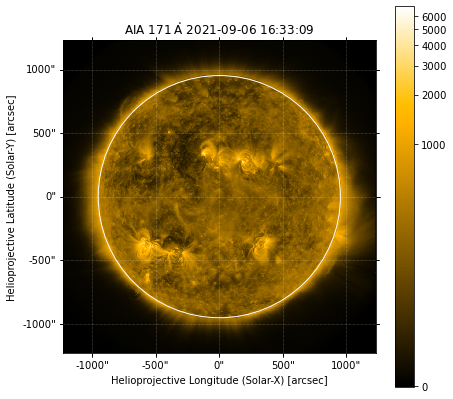

In [148]:
#handler.downloadData()
handler.showData(figsize=(7,7))

### Using the data
For each Layer that was visible in JHelioviewer, a corresponding Layer is created on the handler. They can be accessed indiviualy and provides the same method as the handler. Additionaly, the actual data as well as metadata is accessible.

The metadata can easily be accessed for each layer

In [149]:
layer = handler.layers[0]
print("Timestamp:\t", layer.timestamp)
print("Observatory:\t", layer.observatory)
print("Instrument:\t", layer.instrument)
print("Detector:\t", layer.detector)
print("Measurement:\t", layer.measurement)

Timestamp:	 2021-09-06 16:33:45.347000
Observatory:	 SDO
Instrument:	 AIA
Detector:	 
Measurement:	 171


The data itself for each layer is available as a sunpy.Map in a list named smap. The data itself for each layer is available as a sunpy.Map in a list named smap.

In [150]:
print("Map:")
print(layer.smap[0])
print("Submap:")
print(layer.submap[0])

Map:
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2021-09-06 16:33:09
Exposure Time:		 1.9995919999999998 s
Dimension:		 [1024. 1024.] pix
Coordinate System:	 helioprojective
Scale:			 [2.4000001 2.4000001] arcsec / pix
Reference Pixel:	 [511.5 511.5] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[-0.1875,  0.1875, -0.1875, ...,  0.0625, -0.0625,  0.    ],
       [ 0.125 , -0.1875, -0.125 , ..., -0.375 ,  0.25  ,  0.    ],
       [-0.25  ,  0.125 ,  0.1875, ..., -0.3125,  0.0625,  0.    ],
       ...,
       [ 0.0625, -0.4375,  0.0625, ...,  0.1875, -0.0625,  0.    ],
       [ 0.125 , -0.0625,  0.1875, ...,  0.375 , -0.0625,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., -0.125 ,  0.    ,  0.    ]])
Submap:
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 20